## 3-Satisfiability (3-SAT) Problem

The **3-Satisfiability Problem (3-SAT)** is a classic decision problem in computer science and combinatorial optimization. It is a specific case of the Boolean satisfiability problem (SAT), where each clause in the formula contains **exactly three literals**.

### Definition:
Given:
- A set of Boolean variables $( x_1, x_2, \dots, x_n )$,
- A Boolean formula in **Conjunctive Normal Form (CNF)**, composed of ( m ) clauses, each containing **three literals** (variables or their negations),

The objective is to determine whether there exists an assignment of the variables ( x_i ) such that the entire formula evaluates to **True**.

### Example:
A 3-SAT formula:
$[
(x_1 \lor \neg x_2 \lor x_3) \land (\neg x_1 \lor x_2 \lor x_4) \land (x_2 \lor x_3 \lor \neg x_4)
]$
Here:
- Each clause (e.g., ( x_1 \lor \neg x_2 \lor x_3 )) has exactly three literals.
- The goal is to assign True/False to ( x_1, x_2, x_3, x_4 ) to satisfy the formula.

The 3-SAT problem is **NP-complete**, meaning it is computationally difficult to solve exactly for large inputs, but solutions can be verified efficiently.

## References
[1] Solve utility-scale quantum optimization problems:  
[qiskit QAOA](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)\
[2] 3SAT by [YeYethePooh](https://github.com/YeYethePooh):  
[3SAT benchmark](https://github.com/xjyribro/qubo_benchmarking/tree/main/3SAT)


In [1]:
from sat import ThreeSat
import os
import numpy as np

# problem = os.path.join(os.getcwd(), "Satisfiable\\uf20-91\\uf20-01.cnf")

clauses = np.array([[1, 2, 3],
                    [-1, 2, 3],
                    [1, -2, 3],
                    [-1, 2, -3]])

threesat = ThreeSat.from_clauses(clauses, 3)
print(f"n: {threesat.num_n}, m: {threesat.num_m}")

n: 3, m: 4


## Encode to QUBO

In [2]:
qubo = threesat.qubo("Qiskit")
cost_hamiltonian, offset = qubo['model'], qubo['offset']
print(cost_hamiltonian, f"{offset=}", sep='\n')

SparsePauliOp(['IIIIIZZ', 'IIIIIZI', 'IIIIZIZ', 'IIIIZII', 'IIIZIIZ', 'IIIZIII', 'IIZIIIZ', 'IIZIIII', 'IZIIIIZ', 'IZIIIII', 'ZIIIIIZ', 'ZIIIIII', 'IIIZIZI', 'IIZIIZI', 'IZIIIZI', 'ZIIIIZI', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIIZII'],
              coeffs=[-0.5 +0.j,  0.5 +0.j,  0.5 +0.j,  0.5 +0.j, -0.25+0.j, -0.25+0.j,
  0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
 -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,
 -0.25+0.j,  0.25+0.j])
offset=np.float64(1.0)


## Solve locally

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])


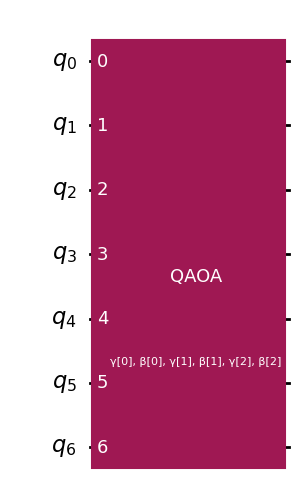

In [3]:
from qiskit.circuit.library import QAOAAnsatz

reps = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
print(circuit.parameters)
circuit.draw('mpl')

## Optimize Circuit

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.3797697954090875
       x: [ 4.257e+00  1.448e+00  2.962e+00  7.264e-01  3.216e+00
            1.717e+00]
    nfev: 72
   maxcv: 0.0


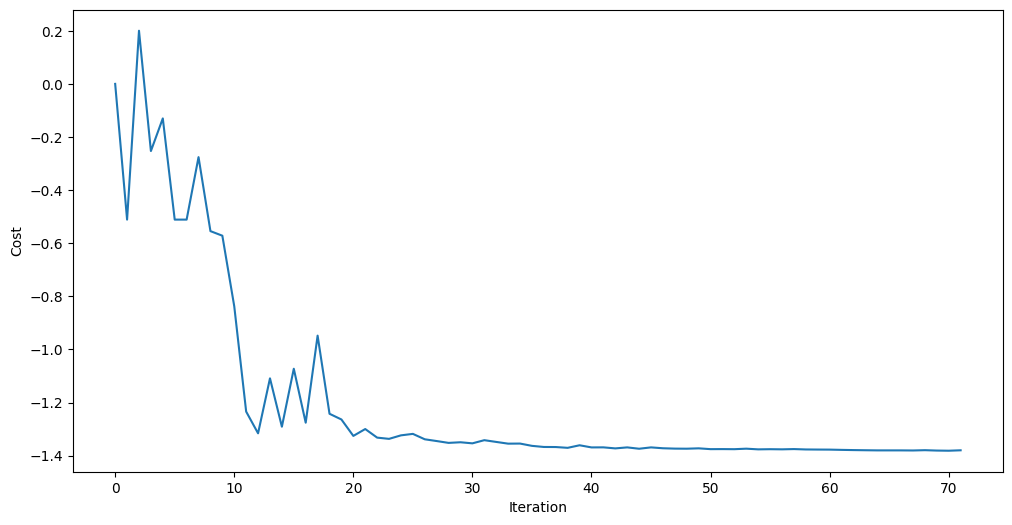

-0.3797697954090875


In [4]:
from utils import QAOA
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator

qaoa = QAOA(circuit, reps=reps)

estimator = Estimator()

result = minimize(
    qaoa.cost_func_estimator,
    qaoa.init_params,
    args=(cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)

print(result)
cost = qaoa.draw_cost_function()
print(cost + offset)

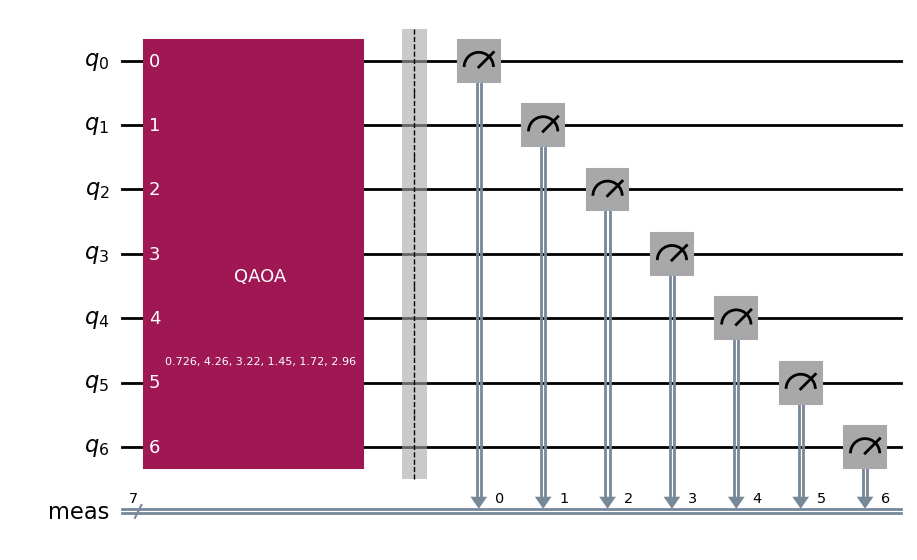

In [5]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

## Run Sampling

In [6]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(default_shots=10000)
# sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
result = job.result()

most_likely_bitstring = threesat.interpret(result, "Qiskit", True)
print("Result bitstring:", most_likely_bitstring)

distribution: 
 {94: 0.0419, 63: 0.0466, 107: 0.0032, 84: 0.0047, 82: 0.0186, 86: 0.0371, 47: 0.0377, 36: 0.0406, 42: 0.0021, 22: 0.0331, 44: 0.0061, 72: 0.0009, 78: 0.0056, 58: 0.0016, 75: 0.0396, 11: 0.025, 83: 0.0073, 52: 0.0412, 30: 0.0238, 0: 0.0287, 67: 0.04, 39: 0.0071, 4: 0.033, 33: 0.0161, 54: 0.0097, 45: 0.0184, 62: 0.0063, 59: 0.0007, 14: 0.0099, 43: 0.0049, 85: 0.002, 66: 0.0178, 15: 0.0308, 114: 0.0006, 96: 0.0066, 20: 0.0198, 3: 0.0337, 127: 0.004, 23: 0.0076, 70: 0.0086, 1: 0.0279, 68: 0.0136, 95: 0.0053, 24: 0.0009, 37: 0.0179, 17: 0.0017, 87: 0.0036, 118: 0.0071, 29: 0.002, 100: 0.0078, 119: 0.003, 55: 0.0059, 99: 0.0084, 6: 0.0075, 31: 0.0245, 79: 0.01, 28: 0.0013, 46: 0.0025, 35: 0.0118, 2: 0.0022, 48: 0.0025, 19: 0.0014, 73: 0.0028, 80: 0.0024, 92: 0.0005, 10: 0.0017, 101: 0.0014, 126: 0.0041, 91: 0.0007, 93: 0.0016, 40: 0.0002, 64: 0.016, 25: 0.0013, 103: 0.0028, 38: 0.0031, 111: 0.0045, 110: 0.0039, 13: 0.0013, 41: 0.0029, 97: 0.0061, 121: 0.0002, 16: 0.0019, 102:

In [7]:
threesat.verify(most_likely_bitstring)

(True, 4, [])

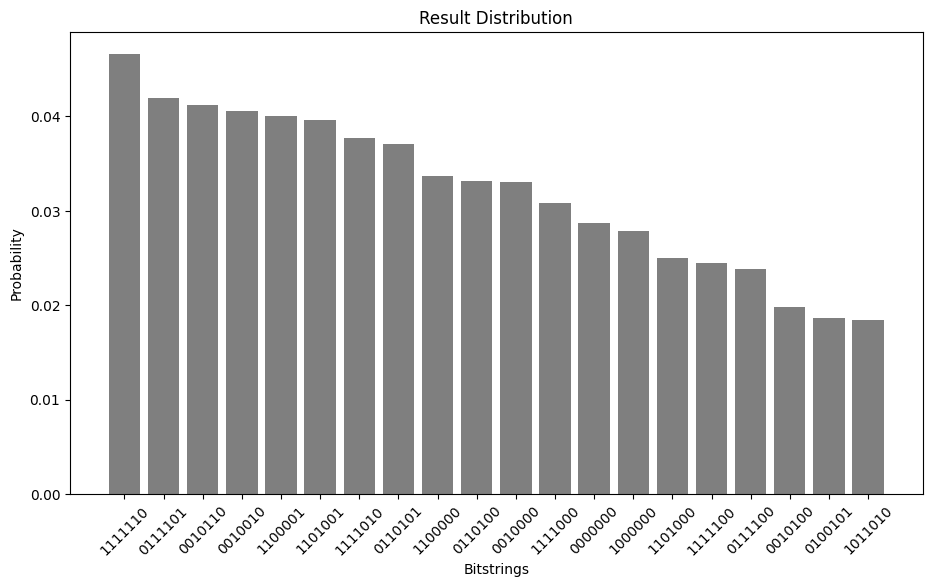

In [8]:
threesat.plot_distribution()